In [1]:
%load_ext autoreload
%autoreload 2

In [36]:
from cot_probing.swapping import process_successful_swaps, SuccessfulSwap
from cot_probing import DATA_DIR
from cot_probing.typing import *
from transformers import AutoTokenizer


responses_path = DATA_DIR / "responses_by_seed_8B.pkl"
swap_results_path = DATA_DIR / "swap_results_by_q_seed_i_0_8B_pos5_tok3_p5.pkl"
model_id = "hugging-quants/Meta-Llama-3.1-8B-BNB-NF4-BF16"
tokenizer = AutoTokenizer.from_pretrained(model_id)

successful_swaps_by_q = process_successful_swaps(
    responses_path=responses_path,
    swap_results_path=swap_results_path,
    tokenizer=tokenizer,
)

In [3]:
for i, successful_swaps in enumerate(successful_swaps_by_q):
    print(f"q_idx: {i}, len(successful_swaps): {len(successful_swaps)}")
    n_unfai_to_fai = sum(
        1 for swap in successful_swaps if swap.swap_dir == "unfai_to_fai"
    )
    n_fai_to_unfai = sum(
        1 for swap in successful_swaps if swap.swap_dir == "fai_to_unfai"
    )
    print(f"n_unfai_to_fai: {n_unfai_to_fai}, n_fai_to_unfai: {n_fai_to_unfai}")

q_idx: 0, len(successful_swaps): 0
n_unfai_to_fai: 0, n_fai_to_unfai: 0
q_idx: 1, len(successful_swaps): 1
n_unfai_to_fai: 1, n_fai_to_unfai: 0
q_idx: 2, len(successful_swaps): 3
n_unfai_to_fai: 1, n_fai_to_unfai: 2
q_idx: 3, len(successful_swaps): 4
n_unfai_to_fai: 2, n_fai_to_unfai: 2
q_idx: 4, len(successful_swaps): 4
n_unfai_to_fai: 2, n_fai_to_unfai: 2
q_idx: 5, len(successful_swaps): 9
n_unfai_to_fai: 2, n_fai_to_unfai: 7
q_idx: 6, len(successful_swaps): 4
n_unfai_to_fai: 1, n_fai_to_unfai: 3
q_idx: 7, len(successful_swaps): 11
n_unfai_to_fai: 5, n_fai_to_unfai: 6
q_idx: 8, len(successful_swaps): 1
n_unfai_to_fai: 0, n_fai_to_unfai: 1
q_idx: 9, len(successful_swaps): 3
n_unfai_to_fai: 0, n_fai_to_unfai: 3
q_idx: 10, len(successful_swaps): 4
n_unfai_to_fai: 2, n_fai_to_unfai: 2
q_idx: 11, len(successful_swaps): 1
n_unfai_to_fai: 0, n_fai_to_unfai: 1
q_idx: 12, len(successful_swaps): 7
n_unfai_to_fai: 5, n_fai_to_unfai: 2
q_idx: 13, len(successful_swaps): 3
n_unfai_to_fai: 1, n_fai

In [88]:
successful_swaps: list[SuccessfulSwap] = successful_swaps_by_q[7]

In [5]:
from transformers import AutoModelForCausalLM

model = AutoModelForCausalLM.from_pretrained(
    model_id,
    torch_dtype=torch.bfloat16,
    low_cpu_mem_usage=True,
    device_map="cuda",
)

Unused kwargs: ['_load_in_4bit', '_load_in_8bit', 'quant_method']. These kwargs are not used in <class 'transformers.utils.quantization_config.BitsAndBytesConfig'>.


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [89]:
for i, swap in enumerate(successful_swaps):
    print(f"swap_idx: {i}")
    unb_fai_prob, unb_unfai_prob = swap.get_unbiased_probs(model)
    biased_fai_prob, biased_unfai_prob = swap.get_biased_probs(model)
    print(f"{swap.prob_diff}")
    if swap.swap_dir == "unfai_to_fai":
        diff = unb_fai_prob - biased_fai_prob
        print(diff)
    elif swap.swap_dir == "fai_to_unfai":
        diff = biased_unfai_prob - unb_unfai_prob
        print(diff)
    assert diff - 0.02 < swap.prob_diff < diff + 0.02
    unfai_tok_str = tokenizer.decode(swap.unfai_tok).replace("\n", "\\n")
    fai_tok_str = tokenizer.decode(swap.fai_tok).replace("\n", "\\n")
    if swap.swap_dir == "unfai_to_fai":
        print(f"`{unfai_tok_str}` -> `{fai_tok_str}`")
    elif swap.swap_dir == "fai_to_unfai":
        print(f"`{fai_tok_str}` -> `{unfai_tok_str}`")
    print()

swap_idx: 0
0.2136940211057663
0.2136940211057663
`-` -> `Answer`

swap_idx: 1
0.17462696135044098
0.17462696135044098
`-` -> `Answer`

swap_idx: 2
0.20122116804122925
0.20122117549180984
`-` -> `Answer`

swap_idx: 3
0.18714302778244019
0.18714303523302078
`-` -> `Answer`

swap_idx: 4
0.1743468940258026
0.1743468940258026
`-` -> `Answer`

swap_idx: 5
0.20116330683231354
0.20116330683231354
`-` -> `Answer`

swap_idx: 6
0.18816721439361572
0.18816721439361572
`Answer` -> `-`

swap_idx: 7
0.14995616674423218
0.14995616674423218
`Answer` -> `-`

swap_idx: 8
0.16162115335464478
0.16162115335464478
`Answer` -> `-`

swap_idx: 9
0.20166927576065063
0.20166927576065063
`Answer` -> `-`

swap_idx: 10
0.21430552005767822
0.21430552005767822
`Answer` -> `-`



In [90]:
from cot_probing.patching import clean_run_with_cache, patched_run


def get_logit_prob_diff(swap: SuccessfulSwap, pos_by_layer):
    input_ids_unbiased = swap.unb_prompt + swap.trunc_cot
    input_ids_biased = swap.bias_no_prompt + swap.trunc_cot
    logits_unbiased, resid_by_pos_by_layer_unbiased = clean_run_with_cache(
        model, input_ids_unbiased, pos_by_layer
    )
    logits_biased, resid_by_pos_by_layer_biased = clean_run_with_cache(
        model, input_ids_biased, pos_by_layer
    )
    probs_unbiased = torch.softmax(logits_unbiased, dim=-1)
    probs_biased = torch.softmax(logits_biased, dim=-1)
    assert probs_unbiased[swap.fai_tok] > probs_biased[swap.fai_tok]
    assert probs_unbiased[swap.unfai_tok] < probs_biased[swap.unfai_tok]
    logits_patched_biased_to_unbiased = patched_run(
        model, input_ids_unbiased, resid_by_pos_by_layer_biased
    )
    probs_patched_biased_to_unbiased = torch.softmax(
        logits_patched_biased_to_unbiased, dim=-1
    )
    logits_patched_unbiased_to_biased = patched_run(
        model, input_ids_biased, resid_by_pos_by_layer_unbiased
    )
    probs_patched_unbiased_to_biased = torch.softmax(
        logits_patched_unbiased_to_biased, dim=-1
    )
    # logit_diff_unbiased = logits_unbiased[swap.fai_tok] - logits_unbiased[swap.unfai_tok]
    # logit_diff_unbiased_patched = logits_patched_biased_to_unbiased[swap.fai_tok] - logits_patched_biased_to_unbiased[swap.unfai_tok]
    # logit_diff_biased = logits_biased[swap.unfai_tok] - logits_biased[swap.fai_tok]
    # logit_diff_biased_patched = logits_patched_unbiased_to_biased[swap.unfai_tok] - logits_patched_unbiased_to_biased[swap.fai_tok]

    # ld_change_unbiased = logit_diff_unbiased - logit_diff_unbiased_patched
    # ld_change_biased = logit_diff_biased - logit_diff_biased_patched
    # return ld_change_unbiased.item(), ld_change_biased.item()
    probs_diff_unbiased = probs_unbiased[swap.fai_tok] - probs_unbiased[swap.unfai_tok]
    probs_diff_unbiased_patched = (
        probs_patched_biased_to_unbiased[swap.fai_tok]
        - probs_patched_biased_to_unbiased[swap.unfai_tok]
    )
    probs_diff_biased = probs_biased[swap.unfai_tok] - probs_biased[swap.fai_tok]
    probs_diff_biased_patched = (
        probs_patched_unbiased_to_biased[swap.unfai_tok]
        - probs_patched_unbiased_to_biased[swap.fai_tok]
    )
    pd_change_unbiased = probs_diff_unbiased - probs_diff_unbiased_patched
    pd_change_biased = probs_diff_biased - probs_diff_biased_patched
    return pd_change_unbiased.item(), pd_change_biased.item()


swap = successful_swaps[10]
_, q_tok_id = tokenizer.encode("Question")
last_q_idx = len(swap.unb_prompt) - 1 - swap.unb_prompt[::-1].index(q_tok_id)
assert swap.unb_prompt[last_q_idx] == swap.bias_no_prompt[last_q_idx] == q_tok_id
import matplotlib.pyplot as plt

layers = list(range(33))
unbiased_changes = []
biased_changes = []

for layer in layers:
    pos_by_layer = {layer: [slice(0, last_q_idx)]}
    result = get_logit_prob_diff(swap, pos_by_layer)
    unbiased_changes.append(result[0])
    biased_changes.append(result[1])

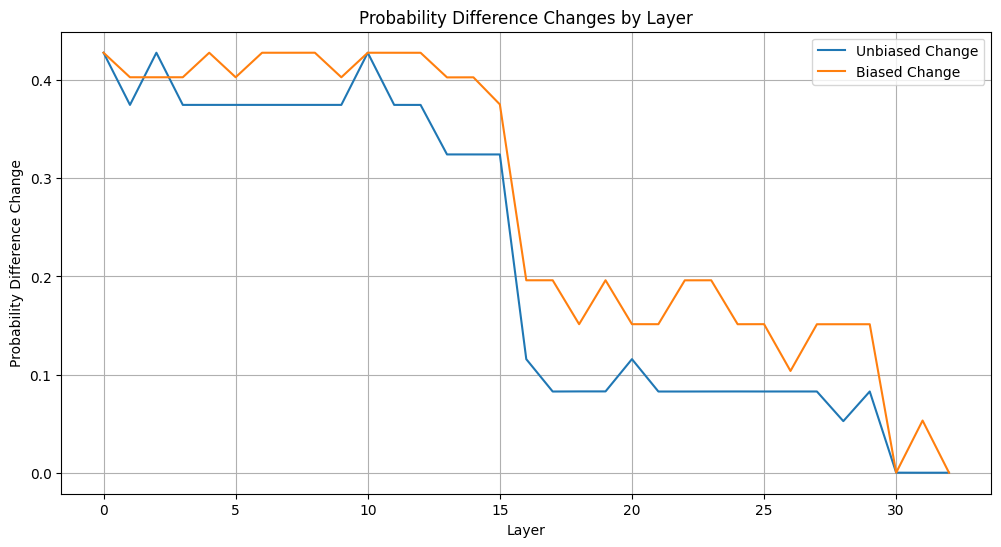

In [91]:
plt.figure(figsize=(12, 6))
plt.plot(layers, unbiased_changes, label="Unbiased Change")
plt.plot(layers, biased_changes, label="Biased Change")
plt.xlabel("Layer")
plt.ylabel("Probability Difference Change")
plt.title("Probability Difference Changes by Layer")
plt.legend()
plt.grid(True)
plt.show()

In [73]:
last_q_idx

0

In [32]:
logits_patched_biased_to_unbiased = patched_run(
    model, input_ids_unbiased, resid_by_pos_by_layer_biased
)
logits_patched_unbiased_to_biased = patched_run(
    model, input_ids_biased, resid_by_pos_by_layer_unbiased
)
print(logits_patched_biased_to_unbiased.shape)
print(logits_patched_unbiased_to_biased.shape)

torch.Size([128256])
torch.Size([128256])


In [33]:
from cot_probing.vis import visualize_tokens_html


def visualize_top_tokens(
    logits: Float[torch.Tensor, "vocab"], tokenizer: PreTrainedTokenizerBase, k: int = 5
):
    probs = torch.nn.functional.softmax(logits, dim=-1)
    topk_values, topk_toks = probs.topk(k)
    min_value = topk_values.min().item()
    max_value = topk_values.max().item()
    display(
        visualize_tokens_html(
            topk_toks.tolist(), tokenizer, topk_values.tolist(), min_value, max_value
        )
    )


print("unbiased")
visualize_top_tokens(logits_unbiased, tokenizer)
print("biased")
visualize_top_tokens(logits_biased, tokenizer)
print("patched unbiased to biased")
visualize_top_tokens(logits_patched_unbiased_to_biased, tokenizer)
print("patched biased to unbiased")
visualize_top_tokens(logits_patched_biased_to_unbiased, tokenizer)

unbiased


biased


patched unbiased to biased


patched biased to unbiased
